# Benchmark models: EfficientNet

# Imports

In [1]:
import matplotlib.pyplot as plt

import torch

from torch.utils.data import DataLoader

from torchaudio import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar

import IPython.display as ipd

#### Augmentation module for our datapipeline

In [2]:
from experiments.models.benchmark_models import LightningEfficientNet
from gadme.utils.preprocess import collate_batch, create_dataset, undo_standardize_tensor

# Define configuration file

In [3]:
config_datapipeline = {"use_spectrogram": True,
                       "n_fft": 1024, # The height of the spectrogram will be n_fft // 2 + 1
                       "hop_length": 512, # The number of frames in the spectrogram (i.e. it's width) will be (audio_length - n_fft) // hop_length + 1, where audio_length is the length of the audio signal.
                       "n_mels": None,
                       "waveform_augmentations": {"colored_noise": {"prob": 0.5, "min_snr_in_db": 3.0, "max_snr_in_db": 30.0,
                                                                    "min_f_decay": -2.0, "max_f_decay": 2.0,},
                                                  #"background_noise": {"background_paths": "/mnt/home/rheinrich/deep_bird_detect/datapipeline/speech_command_dataset" ,"prob":0.5,
                                                  #                     "min_snr_in_db": 3.0, "max_snr_in_db": 30.0,},
                                                  #"pitch_shift": {"prob": 0.5, "min_transpose_semitones": -4.0, "max_transpose_semitones": 4.0,},
                                                 },
                       "spectrogram_augmentations": {"time_masking": {"time_mask_param": 100, "prob": 0.5},
                                                     "frequency_masking": {"freq_mask_param": 100, "prob": 0.5},
                                                     "time_stretch": {"prob": 0.5, "min_rate": 0.8, "max_rate": 1.2}},
                       "learning_rate": 0.01,
                       "batch_size": 64,
                       "num_workers": 32,
                      }

# Create a HuggingFace dataset

### Here, we use the ESC50 dataset

In [4]:
train_dataset, train_push_dataset, test_dataset, train_mean, train_std = create_dataset(path = "ashraq/esc50",
                                                                                        split = "train",
                                                                                        columns = ["audio", "target"],
                                                                                        test_size = 0.2,
                                                                                        use_spectrogram = config_datapipeline["use_spectrogram"],
                                                                                        waveform_augmentations = config_datapipeline["waveform_augmentations"],
                                                                                        spectrogram_augmentations =config_datapipeline["spectrogram_augmentations"],
                                                                                        n_fft = config_datapipeline["n_fft"],
                                                                                        hop_length = config_datapipeline["hop_length"],
                                                                                        n_mels = config_datapipeline["n_mels"],
                                                                                       )

Repo card metadata block was not found. Setting CardData to empty.


# Show transformations

#### Input values & targets

(9,)


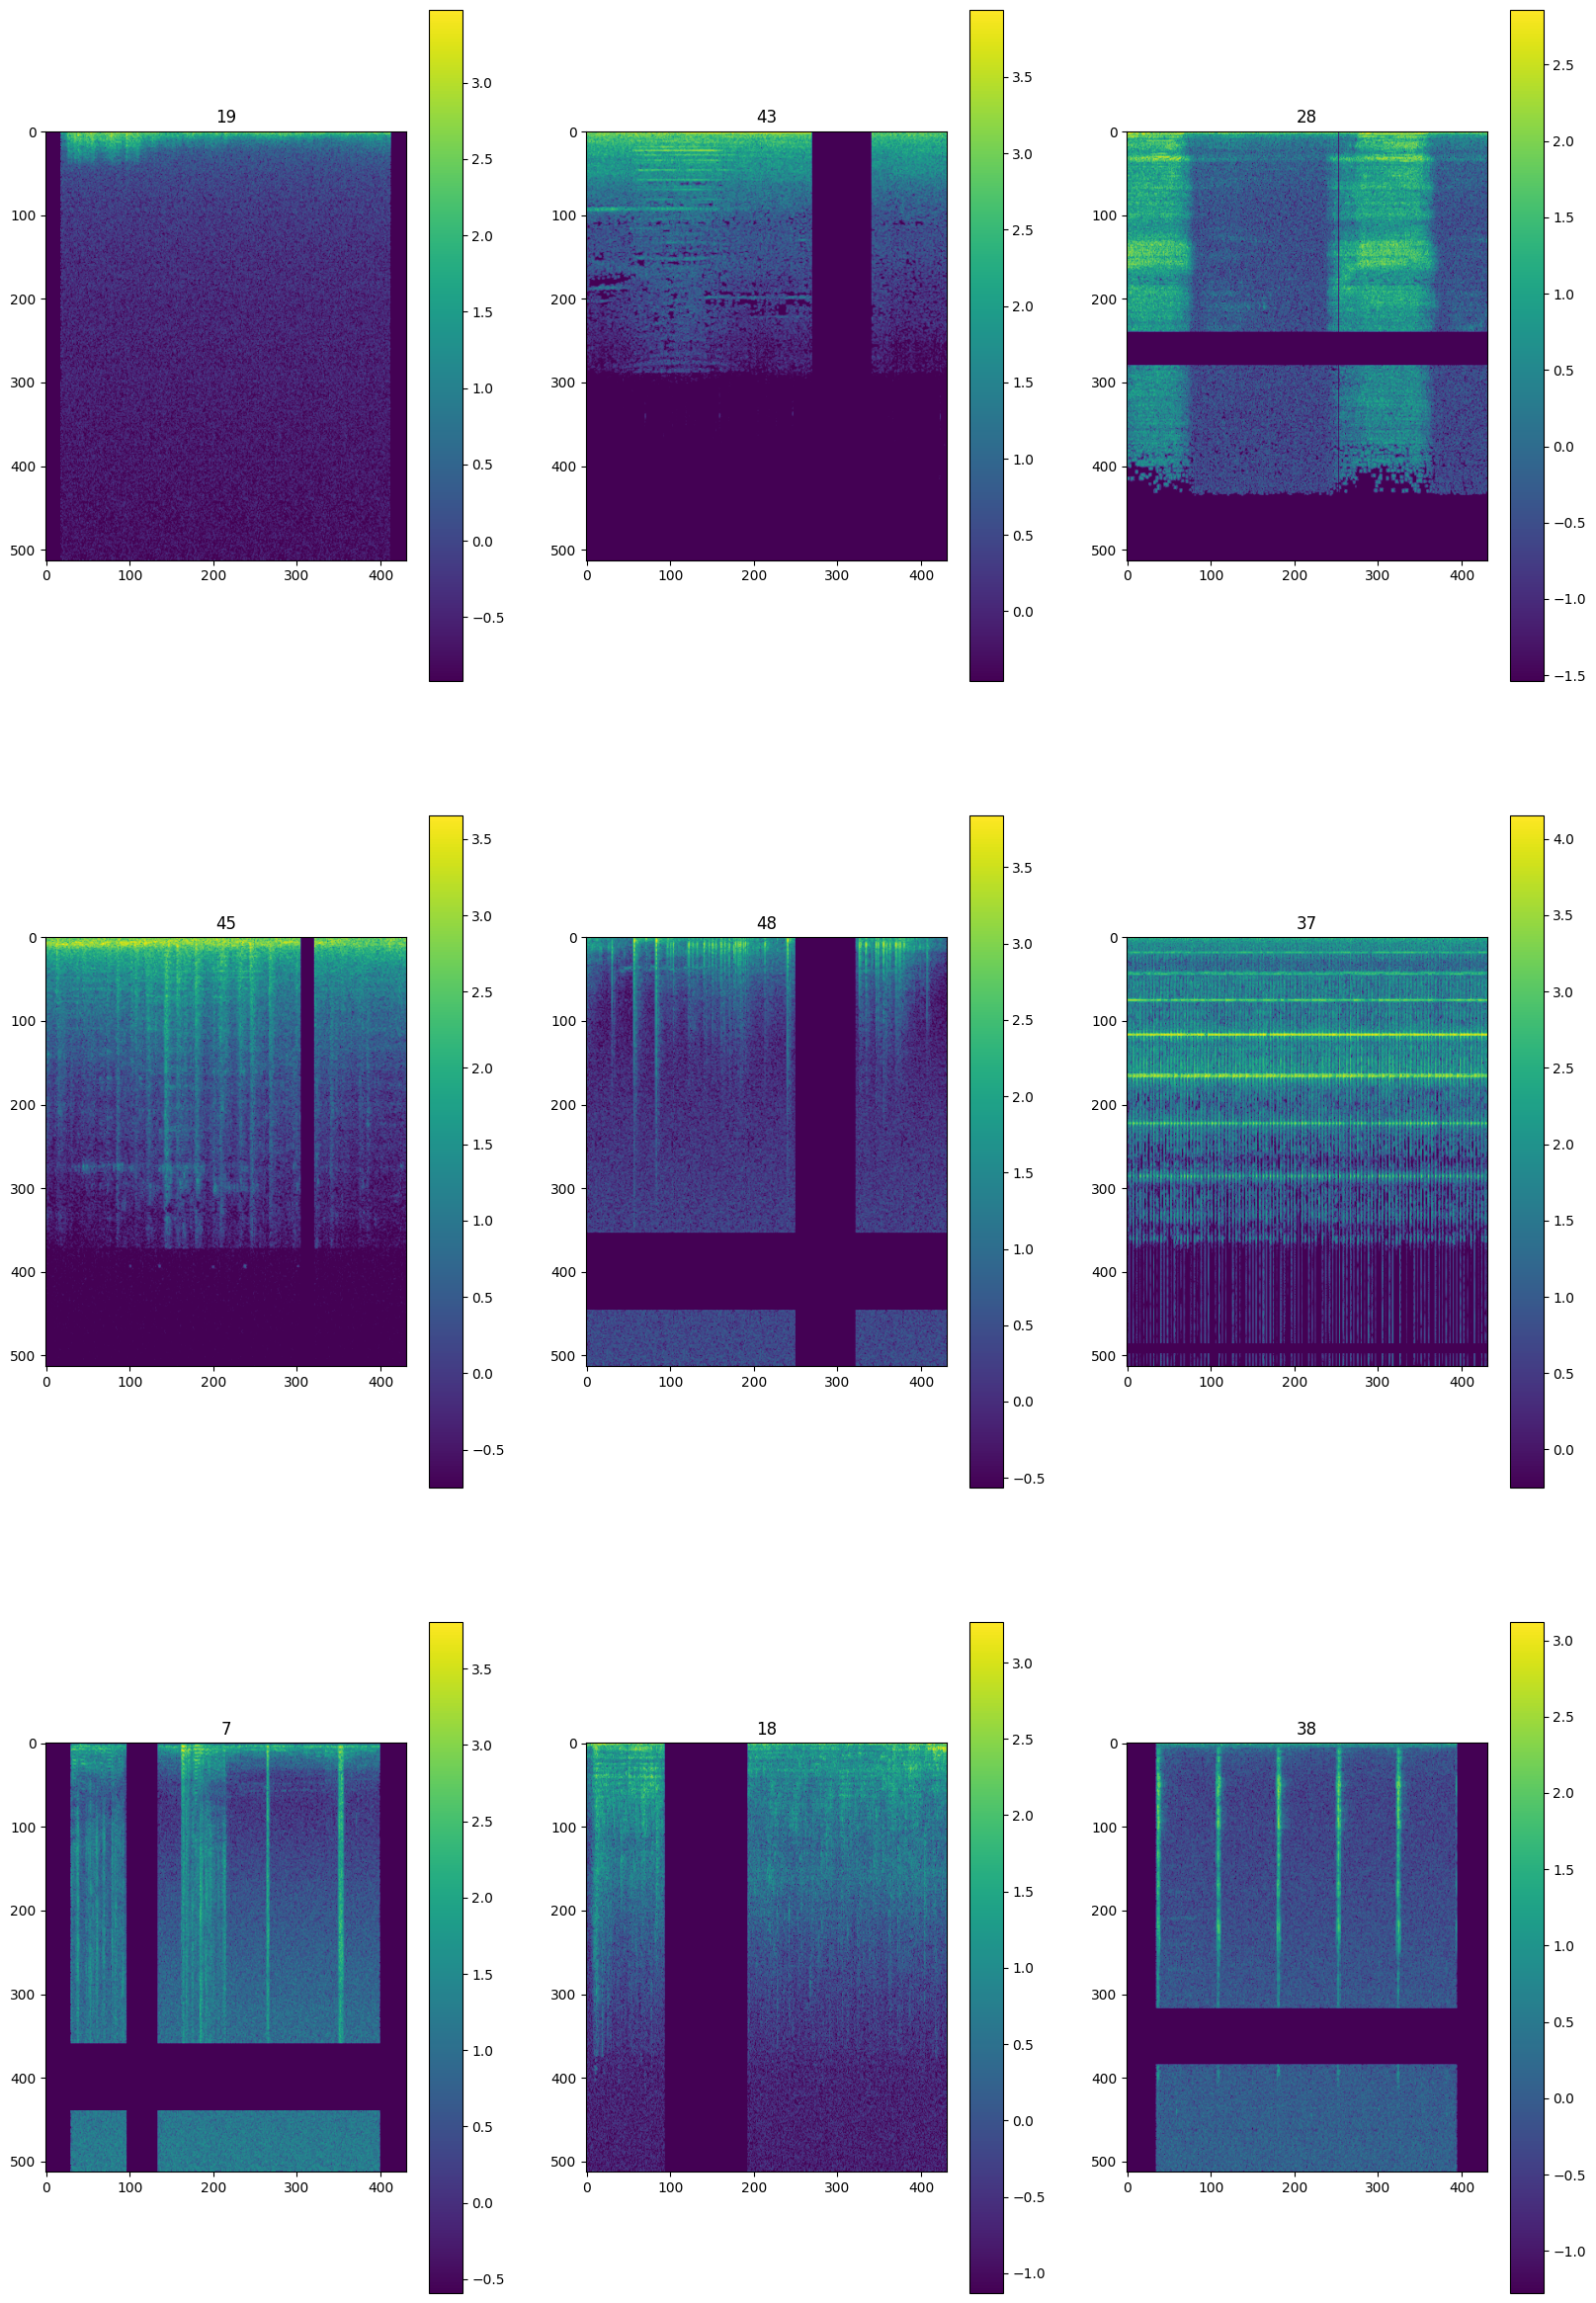

In [5]:
fig, axs = plt.subplots(3,3, figsize=(20, 30))
axs = axs.flatten()
print(axs.shape)
examples = train_dataset[:9]
spectrograms = examples["input_values"]
labels = examples["target"]
for spectrogram, label, ax in zip(spectrograms, labels, axs):
    ax.set_title(label)
    im = ax.imshow(spectrogram.squeeze().numpy())
    fig.colorbar(im, ax = ax)   

#### Convert one spectrogram back to waveform audio data

The GriffinLim transformation converts power spectrograms back to waveform.

If Mel-scale spectrograms are used instead, the InverseMelScale transformation has to be applied first, see https://pytorch.org/audio/stable/transforms.html.

In [6]:
n_fft = config_datapipeline["n_fft"]
hop_length=config_datapipeline["hop_length"]
#n_stft= n_fft // 2 + 1
#n_mels=config_datapipeline["n_mels"]
#sample_rate=train_dataset[0]["audio"]["sampling_rate"]

The waveform files from InverseMelScale have very poor quality and long runtimes, so we should try to work with power spectrograms instead of mel spectrograms if possible!

In [7]:
#transform_to_waveform = torchvision.transforms.Compose([transforms.InverseMelScale(n_stft=n_stft, n_mels=n_mels, sample_rate=sample_rate, max_iter=10000), transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)])

In [8]:
transform_to_waveform = transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)

#### Select one sample from the training dataset

In [9]:
example = train_dataset[103]
example_spectrogram = example["input_values"]

#### Convert the spectrogram to a waveform

In [10]:
# undo z standardization
example_spectrogram_denormalized = undo_standardize_tensor(x=example_spectrogram.unsqueeze(0), mean=train_mean, std=train_std)

# squeeze batch dimension
example_spectrogram_denormalized = example_spectrogram_denormalized.squeeze(0)

Note: since the spectrogram was log10 transformed in the AudioAugmentor, we also need to invert the log transformation.

In [11]:
# undo log10 transformation
example_spectrogram_denormalized = torch.pow(10, example_spectrogram_denormalized)

In [12]:
example_waveform = transform_to_waveform(example_spectrogram_denormalized)

#### Augmented spectrogram

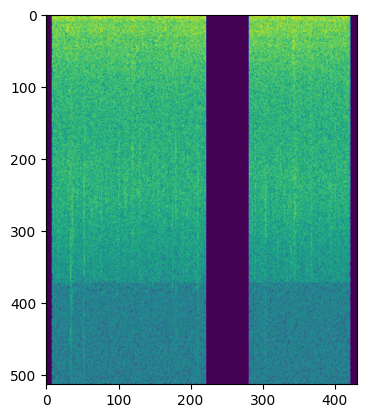

In [13]:
plt.imshow(example_spectrogram.squeeze().numpy())

#### original waveform audio data

In [14]:
original_waveform = example["audio"]["array"]
sample_rate = example["audio"]["sampling_rate"]
ipd.Audio(data=original_waveform, rate=sample_rate)

#### the waveform obtained from the augmented spectrogram.

In [15]:
ipd.Audio(data=example_waveform, rate=sample_rate)

# Create a PyTorch dataloader from the HuggingFace dataset

In [16]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=config_datapipeline["batch_size"], 
                              num_workers=config_datapipeline["num_workers"],
                              shuffle=True, 
                              collate_fn = lambda x: collate_batch(x, return_category=False))

In [17]:
test_dataloader = DataLoader(test_dataset,
                             batch_size=config_datapipeline["batch_size"],
                             num_workers=config_datapipeline["num_workers"],
                             shuffle=False, 
                             collate_fn = lambda x: collate_batch(x, return_category=False))

# Train a benchmark model

### Create Lightning Data Module

In [18]:
class LitDataModule(pl.LightningDataModule):
    def __init__(self,):
        super().__init__()
        
    def setup(self, stage=None):
        pass

    def train_dataloader(self):
        return train_dataloader
    
    def val_dataloader(self):
        return test_dataloader

### Initiate Lightning Data Module

In [19]:
datamodule = LitDataModule()

## Define benchmark model

## Train Model

### Callbacks

In [20]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor= 'val_loss',
    dirpath='./saved_models/benchmark/efficientnet_b0/',
    filename='best_efficientnet_b0_model',
    save_top_k=1,
    mode='min')

In [21]:
early_stopping = pl.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 15)

### Initiate Model and Trainer

In [22]:
model = LightningEfficientNet(baseline_architecture="efficientnet_b0",
                        num_classes=50, 
                        num_channels=1,
                        learning_rate= 0.01,)

In [23]:
trainer = pl.Trainer(max_epochs= 100,
                     accelerator='gpu',
                     devices=1,
                     callbacks=[checkpoint_callback, early_stopping, pl.callbacks.StochasticWeightAveraging(swa_lrs=1e-2), RichProgressBar()],
                     log_every_n_steps=5
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Start Training

In [24]:
# Fit model
trainer.fit(model, datamodule = datamodule)

Epoch 88/100 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25/25 0:00:10 • 0:00:00 3.18it/s v_num: 44 train_loss_step: 1.111  
                                                                                 train_acc_step: 0.672 val_loss:   
                                                                                 2.253 val_acc: 0.5                
                                                                                 train_loss_epoch: 1.177           
                                                                                 train_acc_epoch: 0.632            

### Load best Checkpoint

In [25]:
model = model.load_from_checkpoint('./saved_models/benchmark/efficientnet_b0/best_efficientnet_b0_model.ckpt', 
                                   baseline_architecture="efficientnet_b0",
                                   num_classes=50,
                                   num_channels=1,
                                   learning_rate= config_datapipeline["learning_rate"])

### Validate model

#### Validation set

In [26]:
trainer.validate(model, dataloaders = datamodule)

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 0:00:00 • 0:00:00 11.94it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7124999761581421     │
│         val_loss          │    0.9303020238876343     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.9303020238876343, 'val_acc': 0.7124999761581421}]